In [33]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

model = torch.hub.load(
    "facebookresearch/dinov2",
    "dinov2_vits14"
)
model.eval()
model.to(device)


Using cache found in /Users/margo/.cache/torch/hub/facebookresearch_dinov2_main


DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-11): 12 x NestedTensorBlock(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )
  )
  (norm): LayerNorm((384,), eps=1e-06, elementwise_affi

In [34]:
from torchvision import transforms
from PIL import Image

transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=(0.485, 0.456, 0.406),
        std=(0.229, 0.224, 0.225),
    ),
])

def load_image(path):
    img = Image.open(path).convert("RGB")
    return transform(img).unsqueeze(0)


In [35]:
from pathlib import Path
from tqdm import tqdm
import numpy as np
import pandas as pd

BASE = Path("data/aesthetic_unaesthetic/normalized_sampled_aesthetic_unaesthetic")

embeddings = []
meta = []

with torch.no_grad():
    for aesthetic_label in ["aesthetic", "unaesthetic"]:
        folder = BASE / aesthetic_label

        for img_path in tqdm(list(folder.glob("*.jpg"))):
            try:
                culture = img_path.stem.split("_")[0]  # e.g. "albanian"
                x = load_image(img_path).to(device)
                emb = model(x)

                embeddings.append(emb.squeeze().cpu().numpy())
                meta.append({
                    "culture": culture,
                    "aesthetic": aesthetic_label,
                    "path": str(img_path)
                })
            except Exception:
                continue

X = np.vstack(embeddings)
meta_df = pd.DataFrame(meta)


100%|██████████| 355/355 [00:21<00:00, 16.90it/s]


In [ ]:
np.save("dinov2_embeddings.npy", X)
meta_df.to_csv("dinov2_metadata.csv", index=False)

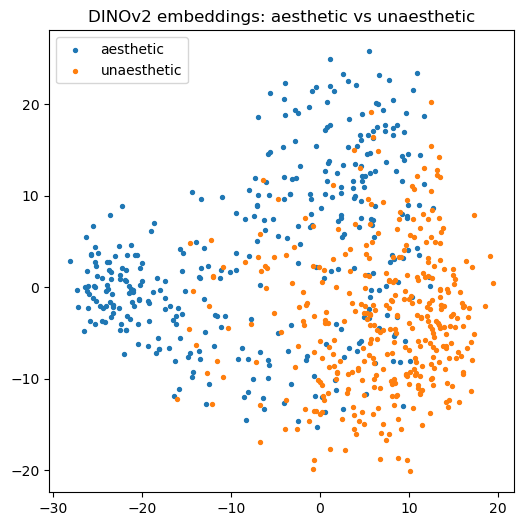

In [37]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(6,6))
for label in ["aesthetic", "unaesthetic"]:
    idx = meta_df["aesthetic"] == label
    plt.scatter(
        X_pca[idx, 0],
        X_pca[idx, 1],
        s=8,
        label=label
    )

plt.legend()
plt.title("DINOv2 embeddings: aesthetic vs unaesthetic")
plt.show()


In [38]:
from sklearn.metrics.pairwise import cosine_distances

centroids = (
    pd.DataFrame(X)
    .assign(culture=meta_df["culture"], aesthetic=meta_df["aesthetic"])
    .groupby(["culture", "aesthetic"])
    .mean()
)

rows = []
for culture in centroids.index.get_level_values(0).unique():
    try:
        a = centroids.loc[(culture, "aesthetic")]
        u = centroids.loc[(culture, "unaesthetic")]
        d = cosine_distances([a], [u])[0, 0]
        rows.append({"culture": culture, "cosine_distance": d})
    except KeyError:
        pass

dist_df = pd.DataFrame(rows).sort_values("cosine_distance", ascending=False)
print(dist_df.head())


       culture  cosine_distance
24     emirati         0.881747
50   namibians         0.866807
43      libyan         0.850979
36  indonesian         0.847138
66        thai         0.845519


In [39]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

k = 10
nbrs = NearestNeighbors(n_neighbors=k+1, metric="cosine").fit(X)
distances, indices = nbrs.kneighbors(X)


In [40]:
labels = meta_df["aesthetic"].values

purities = []

for i in range(len(X)):
    neighbor_idxs = indices[i][1:]  # skip self
    same_label = labels[neighbor_idxs] == labels[i]
    purity = same_label.mean()
    purities.append(purity)

meta_df["knn_purity"] = purities


In [41]:
meta_df.groupby("aesthetic")["knn_purity"].mean()


aesthetic
aesthetic      0.685634
unaesthetic    0.872958
Name: knn_purity, dtype: float64

In [42]:
from sklearn.metrics.pairwise import cosine_similarity

def avg_similarity(X_sub):
    sims = cosine_similarity(X_sub)
    return sims[np.triu_indices_from(sims, k=1)].mean()

aesthetic_X = X[meta_df["aesthetic"] == "aesthetic"]
unaesthetic_X = X[meta_df["aesthetic"] == "unaesthetic"]

avg_similarity(aesthetic_X), avg_similarity(unaesthetic_X)


(np.float32(0.13910502), np.float32(0.33541226))

In [43]:
summary = (
    meta_df
    .groupby(["culture", "aesthetic"])["knn_purity"]
    .mean()
    .reset_index()
)


In [44]:
culture_to_region = {
    # EUROPE
    "albanian": "Europe",
    "armenian": "Europe",
    "austrian": "Europe",
    "azerbaijani": "Europe",
    "belarusian": "Europe",
    "belgian": "Europe",
    "british": "Europe",
    "bulgarian": "Europe",
    "croatian": "Europe",
    "czech": "Europe",
    "dutch": "Europe",
    "estonian": "Europe",
    "finnish": "Europe",
    "french": "Europe",
    "georgian": "Europe",
    "german": "Europe",
    "greek": "Europe",
    "hungarian": "Europe",
    "icelandic": "Europe",
    "italian": "Europe",
    "latvian": "Europe",
    "lithuanian": "Europe",
    "luxembourgers": "Europe",
    "macedonian": "Europe",
    "moldovan": "Europe",
    "norwegian": "Europe",
    "polish": "Europe",
    "portuguese": "Europe",
    "romanian": "Europe",
    "russian": "Europe",
    "serbian": "Europe",
    "slovak": "Europe",
    "slovenian": "Europe",
    "spanish": "Europe",
    "swedish": "Europe",
    "swiss": "Europe",
    "ukrainian": "Europe",

    # EAST ASIA
    "chinese": "East Asia",
    "japanese": "East Asia",
    "south-korean": "East Asia",

    # SOUTH & SOUTHEAST ASIA
    "indian": "South Asia",
    "filipino": "Southeast Asia",
    "indonesian": "Southeast Asia",
    "thai": "Southeast Asia",

    # MIDDLE EAST & NORTH AFRICA
    "bahraini": "Middle East",
    "egyptian": "Middle East",
    "emirati": "Middle East",
    "iranian": "Middle East",
    "libyan": "Middle East",
    "moroccan": "Middle East",
    "syrian": "Middle East",
    "tunisian": "Middle East",
    "turkish": "Middle East",

    # SUB-SAHARAN AFRICA
    "cameroonian": "Sub-Saharan Africa",
    "ethiopian": "Sub-Saharan Africa",
    "kenyan": "Sub-Saharan Africa",
    "namibians": "Sub-Saharan Africa",
    "nigerian": "Sub-Saharan Africa",

    # AMERICAS
    "american": "Americas",
    "argentinean": "Americas",
    "brazilian": "Americas",
    "canadian": "Americas",
    "chilean": "Americas",
    "colombian": "Americas",
    "cuban": "Americas",
    "ecuadorian": "Americas",
    "jamaican": "Americas",
    "mexican": "Americas",
    "peruvian": "Americas",
    "venezuelan": "Americas",

    # OCEANIA
    "australian": "Oceania",
}


In [45]:
summary["region"] = summary["culture"].map(culture_to_region)

region_order = [
    "Europe",
    "East Asia",
    "South Asia",
    "Southeast Asia",
    "Middle East",
    "Sub-Saharan Africa",
    "Americas",
    "Oceania"
]

summary["region"] = pd.Categorical(
    summary["region"],
    categories=region_order,
    ordered=True
)

summary = summary.sort_values(["region", "culture"])


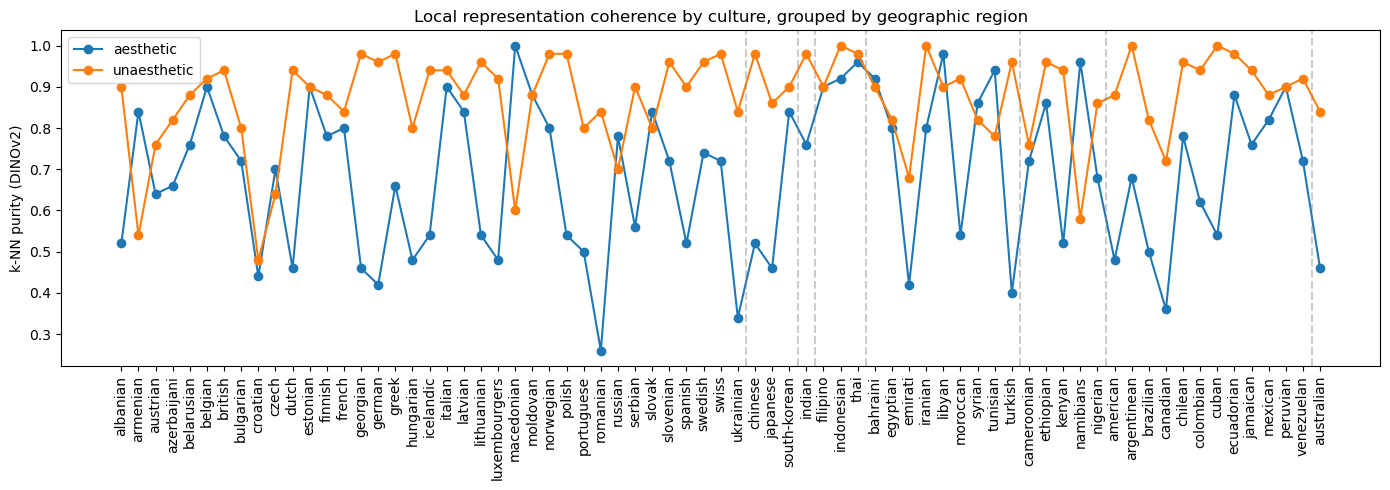

In [46]:
plt.figure(figsize=(14,5))

for label in ["aesthetic", "unaesthetic"]:
    sub = summary[summary["aesthetic"] == label]
    plt.plot(
        sub["culture"],
        sub["knn_purity"],
        marker="o",
        label=label
    )

# region separators
prev_region = None
for i, (_, row) in enumerate(summary.drop_duplicates("culture").iterrows()):
    if prev_region is not None and row["region"] != prev_region:
        plt.axvline(i - 0.5, color="gray", linestyle="--", alpha=0.4)
    prev_region = row["region"]

plt.xticks(rotation=90)
plt.ylabel("k-NN purity (DINOv2)")
plt.title("Local representation coherence by culture, grouped by geographic region")
plt.legend()
plt.tight_layout()
plt.show()


In [47]:
gap = (
    summary
    .pivot(index="culture", columns="aesthetic", values="knn_purity")
    .reset_index()
)

# signed difference
gap["signed_gap"] = gap["aesthetic"] - gap["unaesthetic"]

# sort from most negative → most positive
gap = gap.sort_values("signed_gap")


In [48]:
culture_order = gap["culture"].tolist()

summary_sorted = summary.copy()
summary_sorted["culture"] = pd.Categorical(
    summary_sorted["culture"],
    categories=culture_order,
    ordered=True
)

summary_sorted = summary_sorted.sort_values("culture")


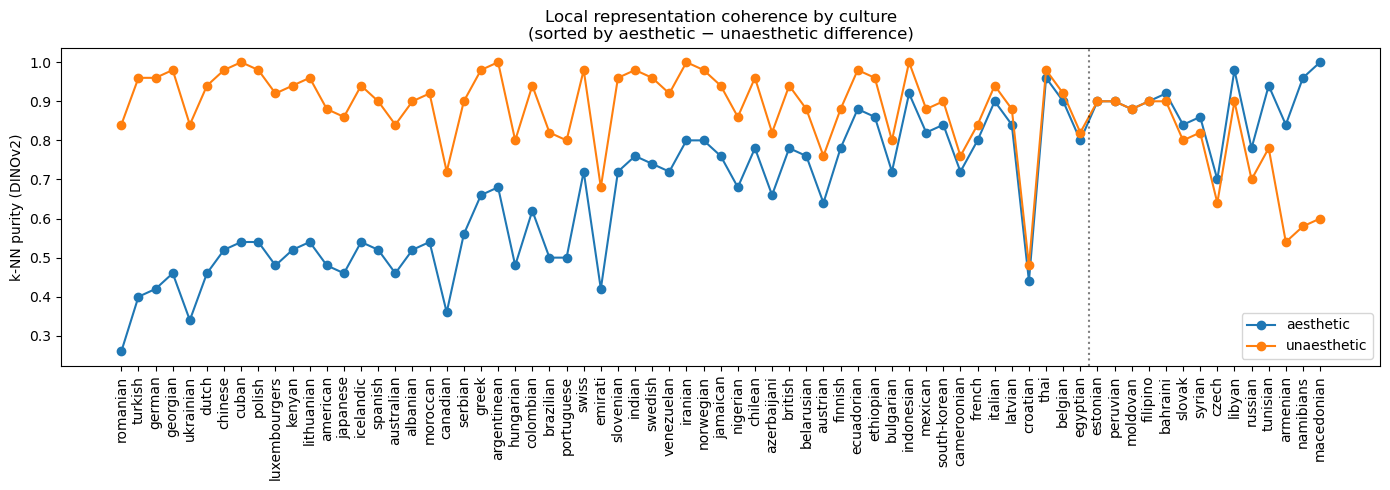

In [49]:
plt.figure(figsize=(14,5))

for label in ["aesthetic", "unaesthetic"]:
    sub = summary_sorted[summary_sorted["aesthetic"] == label]
    plt.plot(
        sub["culture"],
        sub["knn_purity"],
        marker="o",
        label=label
    )

# vertical line at zero-gap midpoint (optional but nice)
zero_idx = gap["signed_gap"].searchsorted(0)
plt.axvline(zero_idx - 0.5, color="black", linestyle=":", alpha=0.5)

plt.xticks(rotation=90)
plt.ylabel("k-NN purity (DINOv2)")
plt.title("Local representation coherence by culture\n(sorted by aesthetic − unaesthetic difference)")
plt.legend()
plt.tight_layout()
plt.show()
